#Relacao da predicao do modelo com o nivel do ruido, após o modelo ser treinado com 30% de ruido


In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 874.1/874.1 kB 19.9 MB/s eta 0:00:00


In [ ]:
import zipfile
import os

# Caminho para o arquivo zip
zip_path = '/content/runs_with_noise.zip'

# Caminho para o diretório onde o conteúdo será extraído
extract_dir = '/content/extracted_files'

# Criar o diretório de extração se não existir
os.makedirs(extract_dir, exist_ok=True)

# Abrir o arquivo zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Extrair todos os arquivos
    zip_ref.extractall(extract_dir)

print(f"Arquivos extraídos para {extract_dir}")


In [ ]:
import zipfile
import os

# Caminho para o arquivo zip
zip_path = '/content/data_val_SNR.zip'

# Caminho para o diretório onde o conteúdo será extraído
extract_dir = '/content/data'

# Criar o diretório de extração se não existir
os.makedirs(extract_dir, exist_ok=True)

# Abrir o arquivo zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Extrair todos os arquivos
    zip_ref.extractall(extract_dir)

print(f"Arquivos extraídos para {extract_dir}")


In [ ]:
import cv2
import numpy as np
import os
import random

def add_gaussian_noise(image, mean=0, sigma=15):
    """
    Adiciona ruído gaussiano a uma imagem.

    Parâmetros:
        image: Imagem de entrada em formato numpy array.
        mean: Média do ruído gaussiano.
        sigma: Desvio padrão do ruído gaussiano.

    Retorno:
        Imagem com ruído adicionado.
    """
    # Gerando ruído gaussiano
    noise = np.random.normal(mean, sigma, image.shape)

    # Adicionando o ruído à imagem
    noisy_image = image + noise

    # Clipping para manter os valores dentro do intervalo válido
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)

    return noisy_image



def add_gaussian_noise_to_random_region(image, mean=0, sigma=15):
    """
    Adiciona ruído gaussiano a uma parte aleatória da imagem.

    Parâmetros:
        image: Imagem de entrada em formato numpy array.
        mean: Média do ruído gaussiano.
        sigma: Desvio padrão do ruído gaussiano.

    Retorno:
        Imagem com ruído adicionado em uma parte aleatória.
    """
    # Obtendo as dimensões da imagem
    height, width, _ = image.shape

    # Definindo um tamanho aleatório para a região (por exemplo, entre 10% e 50% da imagem)
    region_height = random.randint(int(height * 0.1), int(height * 0.5))
    region_width = random.randint(int(width * 0.1), int(width * 0.5))

    # Definindo a posição aleatória para a região
    top_left_x = random.randint(0, width - region_width)
    top_left_y = random.randint(0, height - region_height)

    # Selecionando a região aleatória
    roi = image[top_left_y:top_left_y + region_height, top_left_x:top_left_x + region_width]

    # Gerando ruído gaussiano para a região
    noise = np.random.normal(mean, sigma, roi.shape)

    # Adicionando o ruído à região
    noisy_roi = roi + noise

    # Clipping para manter os valores dentro do intervalo válido
    noisy_roi = np.clip(noisy_roi, 0, 255).astype(np.uint8)

    # Substituindo a região original pela região com ruído
    image[top_left_y:top_left_y + region_height, top_left_x:top_left_x + region_width] = noisy_roi

    return image


In [ ]:
import os
from ultralytics import YOLO

model = YOLO('/content/extracted_files/pose/train/weights/best.pt')

#Ruido

##valid -> original
##valid 1,2 e 3 -> ruido toda imagem
##valid 4,5 e 6 -> ruido a parte da imagem

In [ ]:
import cv2
import numpy as np
import os
import random

input_folder = '/content/data/valid/images'

for i in range(1, 4):
    sigma = [5, 10, 15]
    output_folder = f'/content/data/valid{i}/images'

    output_folder_roi = f'/content/data/valid{i+3}/images'

    # Listar todas as imagens no diretório de entrada
    images = os.listdir(input_folder)

    # Verificar se o diretório de saída existe, caso contrário, criar
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Verificar se o diretório de saída existe, caso contrário, criar
    if not os.path.exists(output_folder_roi):
        os.makedirs(output_folder_roi)

    for name_image in images:
        # Construir o caminho completo da imagem de entrada
        image_path = os.path.join(input_folder, name_image)

        # Carregar a imagem
        image = cv2.imread(image_path)

        # Verificar se a imagem foi carregada corretamente
        if image is None:
            print(f"Erro ao carregar a imagem: {image_path}")
            continue

        # Adicionar ruído à toda imagem
        noisy_image = add_gaussian_noise(image, 0, sigma[i-1])

        # Adicionar ruído à parte da imagem
        noisy_image_roi = add_gaussian_noise_to_random_region(image, 0, sigma[i-1])

        # Definir o caminho completo da imagem de saída
        output_path = os.path.join(output_folder, name_image)
        output_path_roi = os.path.join(output_folder_roi, name_image)

        # Salvar a imagem com ruído
        cv2.imwrite(output_path, noisy_image)
        print(f"Imagem com ruído salva em: {output_path}")

        cv2.imwrite(output_path_roi, noisy_image_roi)
        print(f"Imagem com ruído salva em: {output_path_roi}")

In [ ]:
from ultralytics import YOLO
import yaml

yaml_file = '/content/data/data.yaml'  # Caminho para o arquivo original data.yaml
iterations = 6  # Número de iterações

box_map50_95 = []
box_map50 = []
box_map75 = []
box_map50_95_each = []

pose_map50_95 = []
pose_map50 = []
pose_map75 = []
pose_map50_95_each = []

# Ler o conteúdo original do arquivo
with open(yaml_file, 'r') as file:
    lines = file.readlines()

# Loop para modificar o valor de 'val' no arquivo original
for i in range(1, iterations + 2):

    metrics = model.val(data = yaml_file)

    box_map50_95.append(metrics.box.map)  # mAP50-95
    box_map50.append(metrics.box.map50)   # mAP50
    box_map75.append(metrics.box.map75)   # mAP75
    box_map50_95_each.append(metrics.box.maps)  # Lista de mAP50-95 por categoria

    pose_map50_95.append(metrics.pose.map)  # mAP50-95 para poses
    pose_map50.append(metrics.pose.map50)   # mAP50 para poses
    pose_map75.append(metrics.pose.map75)   # mAP75 para poses
    pose_map50_95_each.append(metrics.pose.maps)  # Lista de mAP50-95 para poses por categoria


    # Percorrer todas as linhas e encontrar a linha que contém 'val:'
    for index, line in enumerate(lines):
        if line.startswith('val:'):
            # Substituir a linha 'val:' pelo novo valor
            lines[index] = f"val: ../valid{i}/images\n"
            break

    # Reescrever o arquivo YAML com a linha 'val' modificada
    with open(yaml_file, 'w') as file:
        file.writelines(lines)



Ultralytics YOLOv8.2.100 🚀 Python-3.10.12 torch-2.4.1+cu121 CPU (Intel Xeon 2.20GHz)
YOLOv8n-pose summary (fused): 187 layers, 3,077,975 parameters, 0 gradients, 8.3 GFLOPs


100%|██████████| 755k/755k [00:00<00:00, 22.1MB/s]
val: Scanning /content/data/valid/labels.cache... 55 images, 0 backgrounds, 0 corrupt: 100%|██████████| 55/55 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:24<00:00,  6.01s/it]


                   all         55        210      0.995      0.995      0.995      0.896      0.995      0.995      0.995       0.99
Speed: 14.5ms preprocess, 404.9ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/pose/val
Ultralytics YOLOv8.2.100 🚀 Python-3.10.12 torch-2.4.1+cu121 CPU (Intel Xeon 2.20GHz)


val: Scanning /content/data/valid1/labels.cache... 55 images, 0 backgrounds, 0 corrupt: 100%|██████████| 55/55 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:23<00:00,  5.90s/it]


                   all         55        210      0.995      0.999      0.995      0.893      0.995      0.999      0.995      0.991
Speed: 10.1ms preprocess, 401.5ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/pose/val2
Ultralytics YOLOv8.2.100 🚀 Python-3.10.12 torch-2.4.1+cu121 CPU (Intel Xeon 2.20GHz)


val: Scanning /content/data/valid2/labels.cache... 55 images, 0 backgrounds, 0 corrupt: 100%|██████████| 55/55 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:30<00:00,  7.51s/it]


                   all         55        210      0.995      0.994      0.995      0.896      0.991      0.995      0.995      0.991
Speed: 21.0ms preprocess, 493.9ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/pose/val3
Ultralytics YOLOv8.2.100 🚀 Python-3.10.12 torch-2.4.1+cu121 CPU (Intel Xeon 2.20GHz)


val: Scanning /content/data/valid3/labels.cache... 55 images, 0 backgrounds, 0 corrupt: 100%|██████████| 55/55 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:24<00:00,  6.10s/it]


                   all         55        210       0.99      0.995      0.995      0.885      0.995          1      0.995      0.991
Speed: 11.4ms preprocess, 404.3ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/pose/val4
Ultralytics YOLOv8.2.100 🚀 Python-3.10.12 torch-2.4.1+cu121 CPU (Intel Xeon 2.20GHz)


val: Scanning /content/data/valid4/labels.cache... 55 images, 0 backgrounds, 0 corrupt: 100%|██████████| 55/55 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:24<00:00,  6.04s/it]


                   all         55        210      0.995      0.995      0.995      0.895      0.995      0.995      0.995       0.99
Speed: 17.8ms preprocess, 402.9ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/pose/val5
Ultralytics YOLOv8.2.100 🚀 Python-3.10.12 torch-2.4.1+cu121 CPU (Intel Xeon 2.20GHz)


val: Scanning /content/data/valid5/labels.cache... 55 images, 0 backgrounds, 0 corrupt: 100%|██████████| 55/55 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:24<00:00,  6.02s/it]


                   all         55        210      0.995      0.999      0.995      0.893      0.995      0.999      0.995      0.991
Speed: 10.5ms preprocess, 411.3ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/pose/val6
Ultralytics YOLOv8.2.100 🚀 Python-3.10.12 torch-2.4.1+cu121 CPU (Intel Xeon 2.20GHz)


val: Scanning /content/data/valid6/labels.cache... 55 images, 0 backgrounds, 0 corrupt: 100%|██████████| 55/55 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:23<00:00,  5.84s/it]


                   all         55        210      0.995      0.999      0.995      0.894      0.995      0.999      0.995      0.991
Speed: 9.4ms preprocess, 398.9ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/pose/val7


In [ ]:
!zip -r /content/runs.zip /content/runs


  adding: content/runs/ (stored 0%)
  adding: content/runs/pose/ (stored 0%)
  adding: content/runs/pose/val6/ (stored 0%)
  adding: content/runs/pose/val6/val_batch2_labels.jpg (deflated 8%)
  adding: content/runs/pose/val6/BoxF1_curve.png (deflated 19%)
  adding: content/runs/pose/val6/PosePR_curve.png (deflated 30%)
  adding: content/runs/pose/val6/confusion_matrix_normalized.png (deflated 41%)
  adding: content/runs/pose/val6/val_batch0_labels.jpg (deflated 7%)
  adding: content/runs/pose/val6/val_batch1_pred.jpg (deflated 7%)
  adding: content/runs/pose/val6/confusion_matrix.png (deflated 40%)
  adding: content/runs/pose/val6/BoxP_curve.png (deflated 24%)
  adding: content/runs/pose/val6/PoseR_curve.png (deflated 20%)
  adding: content/runs/pose/val6/val_batch0_pred.jpg (deflated 7%)
  adding: content/runs/pose/val6/PoseP_curve.png (deflated 24%)
  adding: content/runs/pose/val6/val_batch1_labels.jpg (deflated 7%)
  adding: content/runs/pose/val6/BoxR_curve.png (deflated 20%)
  ad

In [ ]:
import matplotlib.pyplot as plt

def plot_multiple_metrics(sigmas, metrics, labels, title):
    """
    Plota múltiplas métricas em um gráfico, com base nos sigmas de ruído.

    Parâmetros:
    - sigmas: Lista de valores de sigma (níveis de ruído aplicados).
    - metrics: Lista de listas, onde cada sublista é uma métrica (mAP50, mAP50-95, etc.).
    - labels: Lista de rótulos correspondentes às métricas, para uso na legenda.
    - title: Título do gráfico.
    """

    # Criar o gráfico
    plt.figure(figsize=(10, 6))

    # Plotar cada métrica
    for metric, label in zip(metrics, labels):
        plt.plot(sigmas, metric, label=label, marker='o')

    # Adicionar títulos e rótulos
    plt.title(title, fontsize=14)
    plt.xlabel('Sigma do Ruído', fontsize=12)
    plt.ylabel('Desempenho (mAP)', fontsize=12)

    # Definir limites do eixo y
    plt.ylim(0, 1.2)

    # Adicionar legenda e grid
    plt.legend()
    plt.grid(True)

    # Exibir o gráfico
    plt.show()

sigmas = [0, 5, 10, 15]

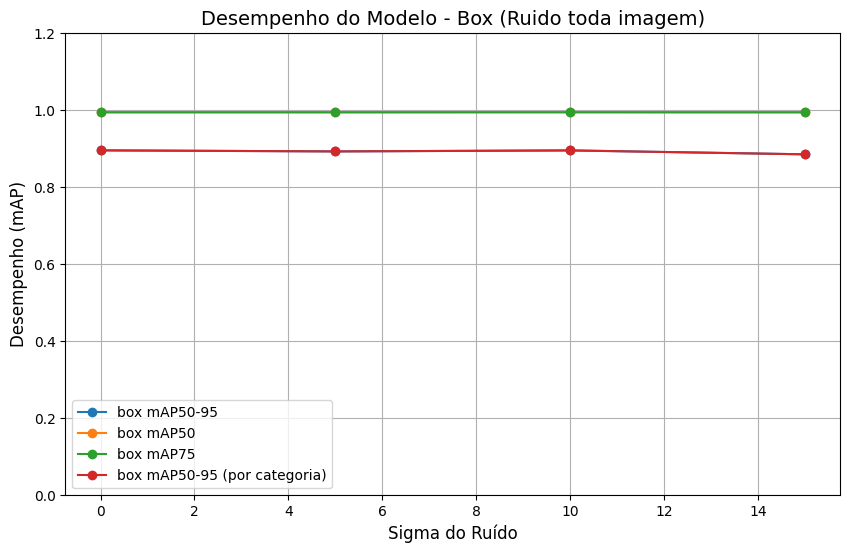

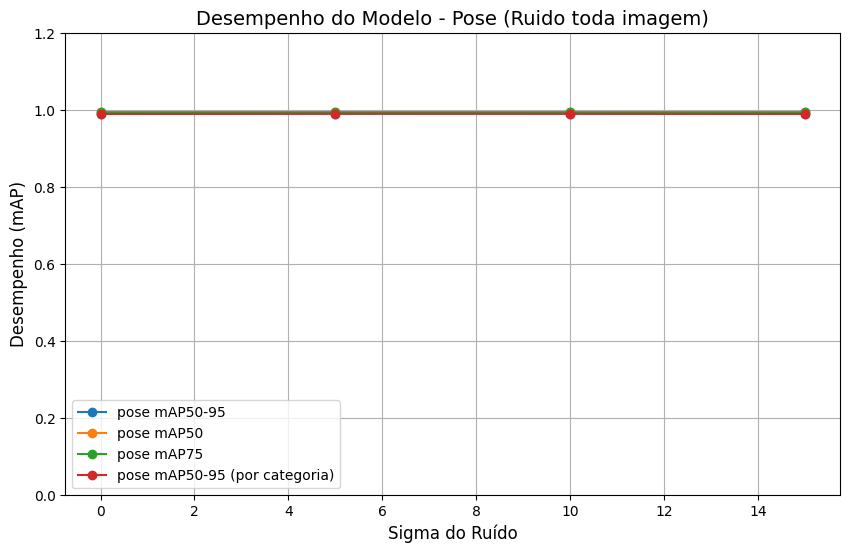

In [ ]:
# Selecionando os primeiros 4 valores
box_metrics = [metric[:4] for metric in [box_map50_95, box_map50, box_map75, box_map50_95_each]]
pose_metrics = [metric[:4] for metric in [pose_map50_95, pose_map50, pose_map75, pose_map50_95_each]]

# Chamando a função para plotar as métricas 'box' com os primeiros 4 valores
plot_multiple_metrics(
    sigmas,
    box_metrics,
    ['box mAP50-95', 'box mAP50', 'box mAP75', 'box mAP50-95 (por categoria)'],
    'Desempenho do Modelo - Box (Ruido toda imagem)'
)

# Chamando a função para plotar as métricas 'pose' com os primeiros 4 valores
plot_multiple_metrics(
    sigmas,
    pose_metrics,
    ['pose mAP50-95', 'pose mAP50', 'pose mAP75', 'pose mAP50-95 (por categoria)'],
    'Desempenho do Modelo - Pose (Ruido toda imagem)'
)


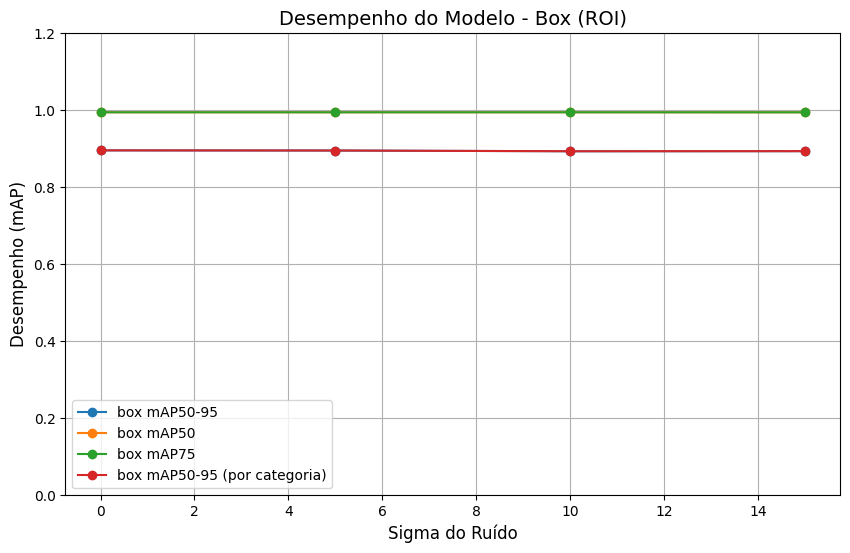

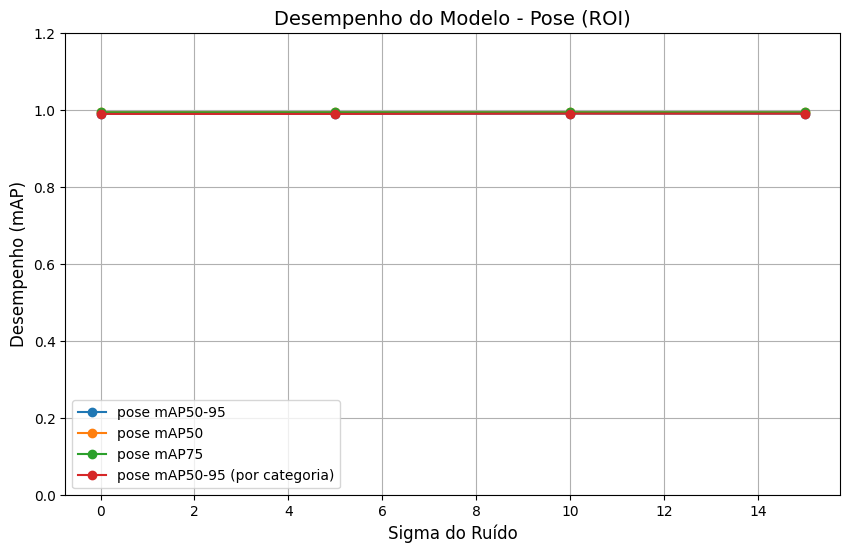

In [ ]:
# Selecionando o primeiro valor e os valores subsequentes após o 4º
box_metrics_roi = [
    [metric[0]] + metric[4:] for metric in [box_map50_95, box_map50, box_map75, box_map50_95_each]
]
pose_metrics_roi = [
    [metric[0]] + metric[4:] for metric in [pose_map50_95, pose_map50, pose_map75, pose_map50_95_each]
]

# Chamando a função para plotar as métricas 'box' com o primeiro valor e valores após o 4º
plot_multiple_metrics(
    sigmas,
    box_metrics_roi,
    ['box mAP50-95', 'box mAP50', 'box mAP75', 'box mAP50-95 (por categoria)'],
    'Desempenho do Modelo - Box (ROI)'
)

# Chamando a função para plotar as métricas 'pose' com o primeiro valor e valores após o 4º
plot_multiple_metrics(
    sigmas,
    pose_metrics_roi,
    ['pose mAP50-95', 'pose mAP50', 'pose mAP75', 'pose mAP50-95 (por categoria)'],
    'Desempenho do Modelo - Pose (ROI)'
)
